<a href="https://colab.research.google.com/github/FaisalT0435/Sistem-Deteksi-Hama-menggunakan-Deep-learning-dan-IoT/blob/main/Fast_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!nvidia-smi

Fri Jan 27 06:17:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
from torchvision import datasets, models

In [8]:
!pip install -U torchvision 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [11]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [12]:
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from albumentations.pytorch import ToTensorV2

Augmentasi

In [14]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [15]:
class PestDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #Memanggil folder sesuai dengan train atau test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # Memanggil file annotaion(bounding box) json sesuai dengan folder  
        self.ids = list(sorted(self.coco.imgs.keys())) #mengurutkan list json dan disimpan ke ids
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)] # memasukkan index yang lebih dari 0 sesuai ids ke id
    
    #mengambil nama image dari file json diurutkan sesuai filename
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    # Menggambil file annotation sesuai dengan id
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        #memanggil bounding box dan  category Id (label) berdasarkan target
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations

        #jika belum di augmentasi maka akan di augmentasi
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        #hasil Augmentasi images di simpan ke image
        image = transformed['image']
        #hasil Augmentasi bounding boxes di simpan ke boxes 
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy

        # merubah ukuran bounding boxes yang sebelumnya (x y w h) menjadi (xmin ymin xmax ymax)
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        #merubah new_boxes ke tensor array supaya bisa berjalan di GPU
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        #merubah array ke tensor array supaya bisa berjalan di GPU
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [16]:
#Memanggil dataset
dataset_path = "/content/drive/MyDrive/Ta/Faster_RCNN/Dataset"

In [17]:
# memanggil label yang terdapat di file annotation
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=13.28s)
creating index...
index created!


{0: {'id': 0, 'name': 'Padi', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Belalang', 'supercategory': 'Padi'},
 2: {'id': 2, 'name': 'Padi', 'supercategory': 'Padi'},
 3: {'id': 3, 'name': 'Ulat', 'supercategory': 'Padi'},
 4: {'id': 4, 'name': 'Wereng', 'supercategory': 'Padi'}}

In [18]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Padi', 'Belalang', 'Padi', 'Ulat', 'Wereng']

In [19]:
# Melakukan Detection pada data train
train_dataset = PestDetection(root=dataset_path, transforms=get_transforms(True))

# Melakukan Detection pada data test
test_dataset = PestDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=4.12s)
creating index...
index created!


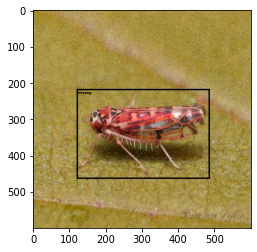

In [20]:
#mencoba memanggil data train sebelum masuk ke model
sample = train_dataset[8]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [21]:
len(train_dataset)

1671

In [22]:
import torch
from tqdm import tqdm
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [23]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [24]:
in_features

1024

In [25]:
model.roi_heads.box_predictor


FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=5, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=20, bias=True)
)

In [26]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [27]:
# def collate_fn(batch):
#   images = list()
#   targets = list()
#   for b in batch:
#         images.append(b[0])
#         targets.append(b[1])
#   images = torch.stack(images, dim=0)
#   return images, targets

In [28]:
#Melakukan 
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [29]:
#memisahkan images (gambar asli) dan targets(dari file annotation)
images,targets = next(iter(train_loader))



In [30]:

images[1]

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9608],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.

In [31]:
targets[1]

{'boxes': tensor([[  8.4375,  85.3125, 495.9375, 573.0469]]),
 'labels': tensor([4]),
 'image_id': tensor([1643]),
 'area': tensor([237770.5000]),
 'iscrowd': tensor([0])}

In [32]:
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

In [33]:
device = torch.device("cuda")

In [34]:
model = model.to(device)

In [35]:
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

optimizer = torch.optim.AdamW(params=model.parameters(),
                                  lr=0.01,
                                  weight_decay=1e-4)

In [36]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    # lr_scheduler = True
    # if epoch == 0:
    #     warmup_factor = 1.0 / 1000 # do lr warmup
    #     warmup_iters = min(1000, len(loader) - 1)
        
    #     lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    for images, targets in tqdm(loader):
      
          images = list(image.to(device) for image in images)
          targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
          
          loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
          losses = sum(loss for loss in loss_dict.values())
          loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
          loss_value = losses.item()
          
          all_losses.append(loss_value)
          all_losses_dict.append(loss_dict_append)
          
          if not math.isfinite(loss_value):
              print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
              print(loss_dict)
              sys.exit(1)
          
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()
        
        # if lr_scheduler is not None:
        #     lr_scheduler.step() # 
    print(f"Avg train Loss: {np.mean(all_losses)}")
    return np.mean(all_losses)
        
    # all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    # print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
    #     epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
    #     all_losses_dict['loss_classifier'].mean(),
    #     all_losses_dict['loss_box_reg'].mean(),
    #     all_losses_dict['loss_rpn_box_reg'].mean(),
    #     all_losses_dict['loss_objectness'].mean()
    # ))

In [37]:
best_vloss = np.inf
def validate(loader, model, optimizer, device, epoch):
    global best_vloss
    loop = tqdm(loader)
    running_vloss = 0
    for batch_idx, (images, targets) in enumerate(loop):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
          loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        running_vloss += losses
        
    avg_vloss = running_vloss / (batch_idx + 1)
    print(f"Avg Valid Loss: {avg_vloss}")
    if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      # if SAVE_MODEL:
      #       print("Model improved, saving...")
      #       checkpoint = {
      #           "state_dict": model.state_dict(),
      #           "optimizer": optimizer.state_dict(),
      #       }
      #       save_checkpoint(checkpoint, filename=f"1152KaggleBest_second_{epoch}.pth.tar")
    print('\n')
    return avg_vloss

In [38]:
!pip install pyttsx3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:


num_epochs=25
train_error = []
val_error = []
for epoch in range(num_epochs):
    train=train_one_epoch(model, optimizer, train_loader, device, epoch)
    vloss= validate(test_loader, model, optimizer, device, epoch)
    train_error.append(train*100)
    val_error.append(vloss.tolist()*100)
    
  

100%|██████████| 418/418 [05:02<00:00,  1.38it/s]


Avg train Loss: 5.772985406688297e+30


100%|██████████| 140/140 [01:30<00:00,  1.55it/s]


Avg Valid Loss: 5.908362606463644e+30




 79%|███████▉  | 332/418 [03:52<01:00,  1.43it/s]

In [ ]:
# plt.subplot(2, 1, 2)
# plt.plot(train_error, label='Training Loss')
# plt.plot(val_error, label='Validation Loss')
# plt.legend()
# plt.title('Training and Validation Loss')
# plt.axvline(num_epochs, color="gray", label="Epoch")
# # plt.ylabel('merror')
# plt.ylabel('Loss ')

# plt.show()

In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
len(test_dataset)

In [ ]:
print("Score")
for i in range(1,10):
  img, _ = test_dataset[i]
  img_int = torch.tensor(img*255, dtype=torch.uint8)
  with torch.no_grad():
      prediction = model([img.to(device)])
      pred = prediction[0]
  
  print( [classes[i] for i in pred['labels'][pred['scores'] > 0.9].tolist()], ": ",pred['scores'].tolist() )
  fig = plt.figure(figsize=(14, 10))
  plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.9], 
    [classes[i] for i in pred['labels'][pred['scores'] > 0.9].tolist()], width=4
  ).permute(1, 2, 0))

  
  
    
  


In [ ]:
def predict_single_frame(frame):
    images = cv2.resize(frame, [600,600], cv2.INTER_LINEAR)/255
    images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
    images = images.swapaxes(1, 3).swapaxes(2, 3)
    images = list(image.to(device) for image in images)
    
    with torch.no_grad():
      pred = model(images)
    
    # print(pred)
    
    im = images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.float32)
    im2 = np.zeros_like(im).astype(np.float32)
    for i in range(len(pred[0]['boxes'])):
        
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        box=pred[0]['boxes'][i].detach().cpu().numpy()
        lbl=pred[0]['labels'][i].detach().cpu().numpy()
        if (lbl == 1) or (lbl == 3) or (lbl == 4) :
          x = "hama"
        else :
          x = "tidak hama"
        # print(lbl)
        if scr>0.9 :
            cv2.rectangle(im, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,0,1), 2)
            cv2.putText(im, "{0:.2f}%".format(scr*100), (int(box[0]+10), int(box[1])+40), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0,0,1), 2, cv2.LINE_AA)
            cv2.putText(im, x , (int(box[0]+4), int(box[1])+15), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0,0,1), 2, cv2.LINE_AA)
            # im2[:,:,0][box>0.87] = np.random.uniform(0,1)
            # im2[:, :, 1][box > 0.87] = np.random.uniform(0,1)
            # im2[:, :, 2][box > 0.87] = np.random.uniform(0,1)

    return (cv2.addWeighted(im, 0.8, im2, 0.2,0)*255).astype(np.uint8)

In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Ta/Mask_RCNN/Dataset/Uji/2023-01-22_12.17.14.272.png')
model.train(False)

if (cap.isOpened()== False): 
    print("Error opening video stream or file")

images = []   
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        result_frame = predict_single_frame(frame)
        images.append(result_frame)
    else: 
        break

cap.release()

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(result_frame)

In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Ta/Mask_RCNN/Dataset/Uji/2023-01-22_11.55.18.642.png')
model.train(False)

if (cap.isOpened()== False): 
    print("Error opening video stream or file")

images = []   
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        result_frame = predict_single_frame(frame)
        images.append(result_frame)
    else: 
        break

cap.release()

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(result_frame)